In [ ]:
from google.colab import drive 
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!cp -av 'drive/MyDrive/CV/final_project/data_pure.zip' './' 
!unzip -u -q "data_pure.zip"

'drive/MyDrive/CV/final_project/data_pure.zip' -> './data_pure.zip'


In [ ]:
!pip install -U -q tensorflow-addons
!pip install opencv-contrib-python==4.5.2.52

     |████████████████████████████████| 1.1 MB 7.7 MB/s 
     |████████████████████████████████| 57.4 MB 73 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import tensorflow.keras.layers as L
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import cv2
import os
seed = 1
base_dir = './'
image_size=224

df = pd.read_csv(base_dir+"data/train.csv")
df['filename'] = df.apply(lambda row: row['id']+'.jpg',axis=1)

def prep_fn(img):
    img = img.astype(np.float32) / 255.0
    #img = (img - 0.5) * 2
    return img

data_gen_args = dict(preprocessing_function=prep_fn,
                     width_shift_range=0.05,
                     height_shift_range=0.2,
                     zoom_range=0.05,
                     rotation_range=5,
                     horizontal_flip=False,
                     vertical_flip=False,
                     validation_split=0.1)

train_datagen = ImageDataGenerator(**data_gen_args)
val_datagen = ImageDataGenerator(preprocessing_function=prep_fn,validation_split=0.1)

train_generator = train_datagen.flow_from_dataframe(dataframe=df,
                                                    directory=base_dir+'data/train/',
                                                    x_col='filename',
                                                    y_col=['x','y'],
                                                    subset="training",
                                                    batch_size = 32,
                                                    seed=seed,
                                                    shuffle=True,
                                                    class_mode='raw',
                                                    target_size=(224,224))
val_generator = val_datagen.flow_from_dataframe(dataframe=df,
                                                directory=base_dir+'data/train/',
                                                x_col='filename',
                                                y_col=['x','y'],
                                                subset="validation",
                                                batch_size = 32,
                                                seed=seed,
                                                shuffle=True,
                                                class_mode='raw',
                                                target_size=(224,224))

Found 6750 validated image filenames.
Found 750 validated image filenames.


In [ ]:
df_test = pd.read_csv("data/imagenames.csv")
df_test['filename'] = df_test.apply(lambda row: row['id']+'.jpg',axis=1)
df_test['x']=0
df_test['y']=0
test_datagen = ImageDataGenerator(preprocessing_function=prep_fn)
test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                directory=base_dir+'data/test/',
                                                x_col='filename',
                                                y_col=['x','y'],
                                                batch_size = 32,
                                                shuffle=False,
                                                class_mode='raw',
                                                target_size=(224,224))

Found 1200 validated image filenames.


In [ ]:
projection_dim = 128
conv_filters = [32,64, projection_dim]
num_patches = (image_size//2**(len(conv_filters))) **2
num_heads = 3

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = L.Dense(units, activation = tf.nn.gelu)(x)
        x = L.Dropout(dropout_rate)(x)
    return x

In [ ]:
class CCTTokenizer(L.Layer):
    def __init__(self):
        super(CCTTokenizer, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim

        """
        self.conv_model = tf.keras.Model(inputs = Xception_model.get_layer("block1_conv1").input, \
                                         outputs = Xception_model.output)
        for layer in self.conv_model.layers:
            layer.trainable = False
        """
        self.conv_model = keras.Sequential()
        for i in conv_filters:
            self.conv_model.add(
                L.Conv2D(i,(3,3),activation='relu', padding='same')
            )
            self.conv_model.add(
                L.MaxPool2D((2, 2), strides=(2, 2))
            )
        
        self.position_embedding = L.Embedding(
            input_dim = self.num_patches, output_dim = self.projection_dim
        )

    def call(self, images):
        outputs = self.conv_model(images)
        positions = tf.range(start = 0, limit = self.num_patches, delta = 1)
        #print(outputs.shape)
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )+ self.position_embedding(positions)
        #print(tf.shape(reshaped), self.position_embedding(positions).shape)
        return reshaped

In [ ]:
def attention_block(inputs, key_dim, mlp_dim,dropout=0):
    x = L.LayerNormalization(epsilon = 1e-6)(inputs)
    attention_output = L.MultiHeadAttention(
        num_heads = num_heads, key_dim = key_dim, dropout = dropout
    )(x, x)
    if(inputs.shape[-1]==key_dim):
        x = L.Add()([inputs,attention_output])
    skip = x
    x = L.LayerNormalization(epsilon = 1e-6)(x)
    x = mlp(x, hidden_units = mlp_dim, dropout_rate = dropout)
    if(skip.shape[-1]==x.shape[-1]):
        x = L.Add()([skip,x])
    return x

def vision_transformer():
    inputs = L.Input(shape = (image_size, image_size, 3))

    #conv_features= convolution_block(inputs)

    # Encode patches.
    x = CCTTokenizer()(inputs)

    for i in range(4):
        x = attention_block(x, 128, [256,128], 0)


    # Create a [batch_size, projection_dim] tensor.
    x = L.LayerNormalization(epsilon = 1e-6)(x)

    x = x[:,0,:]
    #x = L.GlobalAveragePooling1D()(x) 

    x = L.Dense(64,activation='relu')(x)
    out = L.Dense(2)(x)
    
    # Create the model.
    model = tf.keras.Model(inputs = inputs, outputs = out)
    
    return model

In [ ]:
model = vision_transformer()
model.compile(optimizer = Adam(learning_rate=0.001), 
              loss=MeanAbsoluteError())

In [ ]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
cct_tokenizer_11 (CCTTokenizer) (None, 784, 128)     193600      input_13[0][0]                   
__________________________________________________________________________________________________
layer_normalization_99 (LayerNo (None, 784, 128)     256         cct_tokenizer_11[0][0]           
__________________________________________________________________________________________________
multi_head_attention_44 (MultiH (None, 784, 128)     197888      layer_normalization_99[0][0]     
                                                                 layer_normalization_99[0][

In [ ]:
with tf.device('/device:GPU:0'):
    model.load_weights("drive/MyDrive/CV/Model/CCT")
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    r=model.fit(train_generator, validation_data=val_generator,
                validation_steps=20,steps_per_epoch=211,epochs=100,callbacks=[callback])

Epoch 1/100
211/211 [==============================] - 129s 528ms/step - loss: 4.7739 - val_loss: 13.5229
Epoch 2/100
211/211 [==============================] - 111s 526ms/step - loss: 4.5869 - val_loss: 9.1477
Epoch 3/100
211/211 [==============================] - 111s 524ms/step - loss: 3.8648 - val_loss: 8.8730
Epoch 4/100
211/211 [==============================] - 112s 529ms/step - loss: 3.6828 - val_loss: 9.3367
Epoch 5/100
211/211 [==============================] - 111s 524ms/step - loss: 3.6581 - val_loss: 10.4589
Epoch 6/100
 18/211 [=>............................] - ETA: 1:37 - loss: 3.8390

KeyboardInterrupt: ignored

In [ ]:
model.save_weights("drive/MyDrive/CV/Model/CCT")

In [ ]:
with tf.device('/device:GPU:0'):
    model.load_weights("drive/MyDrive/CV/Model/CCT_all")
    ypred = model.predict(test_generator)
ypred.shape

KeyboardInterrupt: ignored

In [ ]:
model.load_weights("drive/MyDrive/CV/Model/CCT_all")

In [ ]:
def rotate(image, angle, center = None, scale = 1.0):
    (h, w) = image.shape[:2]

    if center is None:
        center = (w / 2, h / 2)

    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))

    return rotated

prediction (left): [[-120.45033    99.441864]]
prediction (right): [[-89.338806 131.61069 ]]


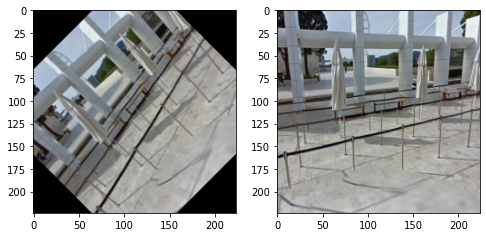

similarity (SIFT): 53.6082


In [ ]:
from matplotlib import pyplot as plt
img1= cv2.imread(os.path.join('data/train/', 'IMG2785_3.jpg'),cv2.IMREAD_UNCHANGED)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1 = cv2.resize(img1, (224,224), interpolation = cv2.INTER_AREA)
img1 = rotate(img1,45)
plt.subplots(figsize=(8, 8))
plt.subplot(1,2,1)
plt.imshow(img1)
img1_in = img1[np.newaxis,:].astype(np.float32)/255.0
print("prediction (left):",model.predict(img1_in))

img2= cv2.imread(os.path.join('data/train/', 'IMG2785_3.jpg'),cv2.IMREAD_UNCHANGED)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2 = cv2.resize(img2, (224,224), interpolation = cv2.INTER_AREA)
plt.subplot(1,2,2)
plt.imshow(img2)
img2_in = img2[np.newaxis,:].astype(np.float32)/255.0
print("prediction (right):",model.predict(img2_in))
plt.show()

img1 = cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY)
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None)

img2 = cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY)
sift = cv2.SIFT_create()
kp2, des2 = sift.detectAndCompute(img2,None)
print("similarity (SIFT):",round(img_similarity(des1,des2)*100,4))

In [ ]:
df_test['x'] = ypred[:,0]
df_test['y'] = ypred[:,1]
if 'filename' in df_test.keys():
    df_test=df_test.drop(columns=['filename'])
df_test.head()
df_test.to_csv('pred_CCT.csv',index=False)

In [ ]:
df_test = pd.read_csv("pred_CCT.csv")
df_test.head()

,id,x,y
0,IMG4287_3,27.379448,-71.373955
1,IMG4288_5,83.970780,-19.311630
2,IMG4289_5,51.305504,1.638904
3,IMG4290_4,-5.204660,-15.307632
4,IMG4291_5,-90.683136,131.574110


In [ ]:
xy = np.array(list(set(tuple(zip(df.x.values,df.y.values)))))
xy

array([[ 12.71932192, -43.01728035],
       [ 57.61932192, -16.31728035],
       [ 32.31932192, -18.51728035],
       ...,
       [ 44.11932192, -70.81728035],
       [ 68.31932192, -61.91728035],
       [ 28.41932192, -70.61728035]])

In [ ]:
point2imgs = {}
img2point = {}
for index,row in df.iterrows():
    img2point[row['filename']] = (row['x'],row['y'])
    if (row['x'], row['y']) not in point2imgs.keys():
        point2imgs[(row['x'], row['y'])] = [row['filename']]
    else:
        point2imgs[(row['x'], row['y'])]. append(row['filename'])
print()

In [ ]:
def m_distance(p1, p2):
    return abs(p1[0]-p2[0]) + abs(p1[1]-p2[1])

def nearest_points(p1,points, k):
    distance = np.zeros((points.shape[0]))
    for i in range(len(points)):
        distance[i] = m_distance(points[i],p1)
    ids = np.argsort(distance)[:k]
    return points[ids]

In [ ]:
def get_descriptor(img_path, des_save_path=None, show_plot = False):
    gray = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(gray,None)
    if des_save_path is not None:
        with open(des_save_path, 'wb') as f:
            np.save(f, des1)
    return des1

def img_similarity(des1, des2, threshold=0.7):
    # FLANN parameters and initialize
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params,search_params)

    # Matching descriptor using KNN algorithm
    matches = flann.knnMatch(des1,des2,k=2)

    # Create a mask to draw all good matches
    matchesMask = []

    # Store all good matches as per Lowe's Ratio test.
    good = []
    for m,n in matches:
        if m.distance < threshold*n.distance:
            good.append(m)
            matchesMask.append([1,0]) # Match
        else:
            matchesMask.append([0,0]) # Mismatch
    n_keypoints = min(len(des1),len(des2))
    score = len(good) / n_keypoints
    #print('similarity:',round(score*100,4))
    return score
base_dir = 'data/'
des1 = get_descriptor(os.path.join(base_dir+'train/', 'IMG2750_3.jpg'))
des2 = get_descriptor(os.path.join(base_dir+'test/', 'IMG4291_5.jpg'))
img_similarity(des1,des2)

0.004206098843322818

In [ ]:
for name in df['id']:
    img_path = base_dir + 'train/' + name + '.jpg'
    des_folder = base_dir + 'train_des/'
    try:
        os.mkdir(des_folder)
    except FileExistsError:
        pass
    des_path = des_folder + name +'_des.npy'
    get_descriptor(img_path, des_path)

In [ ]:
for name in df_test['id']:
    img_path = base_dir + 'test/' + name + '.jpg'
    des_folder = base_dir + 'test_des/'
    try:
        os.mkdir(des_folder)
    except FileExistsError:
        pass
    des_path = des_folder + name +'_des.npy'
    get_descriptor(img_path, des_path)

In [ ]:
refined_x = []
refined_y = []

for index,row in df_test.iterrows():
    img_src = row['id']
    x_pred,y_pred = row['x'], row['y']
    n_images = []
    max_score = 0
    best_img = ""
    for x,y in nearest_points((x_pred,y_pred), xy,3):
        n_images += point2imgs[(x,y)]
    des_path1 = base_dir + 'test_des/' + img_src +'_des.npy'
    des1 = np.load(des_path1,allow_pickle=True)
    #des1 = get_descriptor(os.path.join(base_dir+'train/', img_src))
    for img_name in n_images:
        des_path = base_dir + 'train_des/' + img_name.split('.')[0] +'_des.npy'
        des2 = np.load(des_path,allow_pickle=True)
        #des2 = get_descriptor(os.path.join(base_dir+'train/', img_name))
        try:
            if(des1.any() and des2.any()):
                score = img_similarity(des1,des2)
                if score>max_score:
                    max_score=score
                    best_img = img_name
        except:
            pass
    if(best_img):
        x, y = img2point[best_img]
    else:
        x, y = nearest_points((x_pred,y_pred), xy,1)[0]
    refined_x.append(x)
    refined_y.append(y)

In [ ]:
df_test['x'] = refined_x
df_test['y']=refined_y
df_test.head()

,id,x,y
0,IMG4287_3,28.119322,-73.01728
1,IMG4288_5,86.719322,-24.31728
2,IMG4289_5,50.519322,0.48272
3,IMG4290_4,-10.080678,-9.01728
4,IMG4291_5,-87.080678,128.48272


In [ ]:
df_test.to_csv('pred_CCT_refined_only.csv',index=False)